In [7]:
import pandas as pd
import h5py
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import joblib

In [8]:
keys = ['hydro_07ED002', 'hydro_07EF002', 'hydro_07EF003', 'hydro_08GB013', 'hydro_08HB082', 'hydro_08HD025', 'hydro_08JA022', 'hydro_08JA023', 'hydro_08JA027', 'hydro_08LC018', 'hydro_08LC041', 'hydro_08ME017', 'hydro_08MH141', 'hydro_08MH148', 'hydro_08MH149', 'hydro_08MH167', 'hydro_08NB017', 'hydro_08ND017', 'hydro_08NE102', 'hydro_08NE103', 'hydro_08NE104', 'hydro_08NE107', 'hydro_08NH064', 'hydro_08NH067', 'hydro_08NH127', 'hydro_08NM213', 'hydro_08NM234']
# for key in keys:
#         my_hdf = pd.read_hdf('combined_data.hdf', key=key)
#         print(key, len(my_hdf), len(my_hdf.dropna()))

In [40]:
def plot_errors(model, X_valid, y_valid, output_filename):
    plt.hist(y_valid - model.predict(X_valid), bins=100)
    plt.savefig('models/errors_{}.png'.format(output_filename))
    plt.close()

def plot_model(X_vals, y_vals, model, output_filename):
    plt.plot(X_vals['date'], y_vals, 'b.', alpha=0.5)
    plt.scatter(X_vals['date'], model.predict(X_vals), s=1, alpha=0.5, c='r')
    plt.show()
    plt.savefig('models/predict_{}.png'.format(output_filename))
    plt.close()
    
def plot_df_vals(df):
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(df))
    scaled_df.columns = df.columns
    scaled_df.index = df.index
    plt.plot(scaled_df.index, scaled_df['water_level'], c= 'b')
    plt.plot(scaled_df.index, scaled_df['precip'], c= 'r')
    plt.plot(scaled_df.index, scaled_df['rain'], c= 'yellow')
    plt.plot(scaled_df.index, scaled_df['mean_temp'], c='g')
    plt.plot(scaled_df.index, scaled_df['snow_precip'], c='aqua')
    plt.plot(scaled_df.index, scaled_df['snow_on_grnd'], c='magenta')
    
def model_scores(model, X_train, X_valid, y_train, y_valid):
    return {'train_score': model.score(X_train, y_train), 'valid_score': model.score(X_valid, y_valid)}

def train_and_generate_model(X_train, y_train, C, n_components, scaler):
    imputer = SimpleImputer()
    model = make_pipeline(
        imputer,
        scaler,
        PCA(n_components=n_components), # assume we have some kind of time, precip and temp dimensionality
        SVR(C=C, gamma='scale')
    )
    model.fit(X_train, y_train)
    return model

def prepare_df(df):
    df['date'] = df.index.map(dt.datetime.toordinal)
    X_columns = ['date','year', 'month', 'rain', 'precip', 'mean_temp', 'snow_on_grnd', 'snow_precip']
    y_column = 'water_level'
    X = df[X_columns]
    y = df['water_level'].values
    return (X, y)

In [44]:
def create_models(key,df=None, filter_month=None, show_plot=False, n_components=6, C=100, scaler=MinMaxScaler()):
    if df is None:
        df = pd.read_hdf('combined_data.hdf', key=key).sort_index().dropna()
        if filter_month:
            # only look at a certain month
            df = df[df['month'] == filter_month]
    X, y = prepare_df(df)
    
    if len(df) == 0:
        return None
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)

    model = train_and_generate_model(X_train, y_train, C=C, n_components=n_components, scaler=scaler)
    
    if show_plot:
        plot_model(X, y, model, key)
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
        
    return model_scores(model, X_train, X_valid, y_train, y_valid)

In [10]:
SAVE_MODELS = False

In [33]:
# test best components. 6 looks pretty good
for key in keys:
    df = pd.read_hdf('combined_data.hdf', key=key).sort_index().dropna()
    for i in range(2,8):
        print(key, i, create_models(key, df=df, n_components=i))
    print()
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
    #plot_errors(model, X_valid, y_valid, key)

hydro_07ED002 6 {'valid_score': 0.7695680965428706, 'train_score': 0.7822177942733417}
hydro_07ED002 7 {'valid_score': 0.796565588269364, 'train_score': 0.7736657614114348}

hydro_07EF002 6 {'valid_score': 0.6407625022217076, 'train_score': 0.6584703995843506}
hydro_07EF002 7 {'valid_score': 0.648040640387469, 'train_score': 0.6539772616008779}

hydro_07EF003 6 {'valid_score': 0.772195317204127, 'train_score': 0.7848407315041919}
hydro_07EF003 7 {'valid_score': 0.7606159201200767, 'train_score': 0.7828745922897374}

hydro_08GB013 6 None
hydro_08GB013 7 None

hydro_08HB082 6 {'valid_score': 0.4124051922328251, 'train_score': 0.4409740711735075}
hydro_08HB082 7 {'valid_score': 0.4388642920598863, 'train_score': 0.4313175418140787}

hydro_08HD025 6 {'valid_score': 0.37736073695131206, 'train_score': 0.42380617280926913}
hydro_08HD025 7 {'valid_score': 0.40227606087997986, 'train_score': 0.40644172951263857}

hydro_08JA022 6 {'valid_score': 0.8462579629582334, 'train_score': 0.860492847005

KeyboardInterrupt: 

In [38]:
# test best C. 10e2 seems to be the best between time and scoring tradeoff
for key in keys:
    df = pd.read_hdf('combined_data.hdf', key=key).sort_index().dropna()
    for i in range(-3,4):
        print(key, i, create_models(key, df=df, C=10**i))
    print()
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
    #plot_errors(model, X_valid, y_valid, key)

hydro_07ED002 0 {'valid_score': 0.7654130076785438, 'train_score': 0.7825909095115582}
hydro_07ED002 1 {'valid_score': 0.8421370061107388, 'train_score': 0.8610059584610777}
hydro_07ED002 2 {'valid_score': 0.867023259444077, 'train_score': 0.8882033366004196}
hydro_07ED002 3 {'valid_score': 0.8660772429276996, 'train_score': 0.9079039485013176}

hydro_07EF002 0 {'valid_score': 0.6603539554479383, 'train_score': 0.6612298164616528}
hydro_07EF002 1 {'valid_score': 0.7806184688712732, 'train_score': 0.804394155528202}
hydro_07EF002 2 {'valid_score': 0.8528345731848817, 'train_score': 0.876681592488207}
hydro_07EF002 3 {'valid_score': 0.8541965505774196, 'train_score': 0.9011617572740573}

hydro_07EF003 0 {'valid_score': 0.7963087599945442, 'train_score': 0.7762988861169765}
hydro_07EF003 1 {'valid_score': 0.8255976293182506, 'train_score': 0.8634843893837403}
hydro_07EF003 2 {'valid_score': 0.8364271239026331, 'train_score': 0.8924133435285836}
hydro_07EF003 3 {'valid_score': 0.8566494922

KeyboardInterrupt: 

In [43]:
# test best scaler. minmax looks the best
for key in keys:
    df = pd.read_hdf('combined_data.hdf', key=key).sort_index().dropna()
    print(key, 'standard', create_models(key, df=df, scaler=StandardScaler()))
    print(key, 'minmax', create_models(key, df=df, scaler=MinMaxScaler()))
    print(key, 'robust', create_models(key, df=df, scaler=RobustScaler()))
    print()
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
    #plot_errors(model, X_valid, y_valid, key)

hydro_07ED002 standard {'valid_score': 0.8668743878391608, 'train_score': 0.8916439718135127}
hydro_07ED002 minmax {'valid_score': 0.8829599495891116, 'train_score': 0.9069253356382947}
hydro_07ED002 robust {'valid_score': 0.37249290393186385, 'train_score': 0.4737045083490654}

hydro_07EF002 standard {'valid_score': 0.8577173313160773, 'train_score': 0.8757458879217817}
hydro_07EF002 minmax {'valid_score': 0.8775983090486456, 'train_score': 0.8949324664604096}
hydro_07EF002 robust {'valid_score': 0.33384926563833384, 'train_score': 0.3811740980699138}

hydro_07EF003 standard {'valid_score': 0.8512089977745864, 'train_score': 0.8965884745342665}
hydro_07EF003 minmax {'valid_score': 0.8906261167663726, 'train_score': 0.9065696995655104}
hydro_07EF003 robust {'valid_score': 0.43586645729916207, 'train_score': 0.4623535541293601}

hydro_08GB013 standard None
hydro_08GB013 minmax None
hydro_08GB013 robust None

hydro_08HB082 standard {'valid_score': 0.4519852873027389, 'train_score': 0.552

KeyboardInterrupt: 

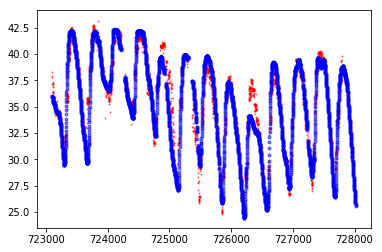

hydro_07ED002 hi {'valid_score': 0.901107812420183, 'train_score': 0.9048610644906387}



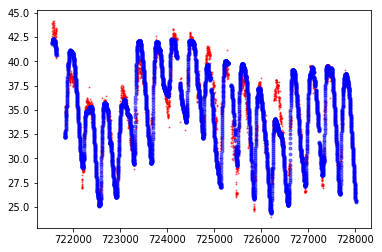

hydro_07EF002 hi {'valid_score': 0.8915235066639733, 'train_score': 0.8920606213923123}



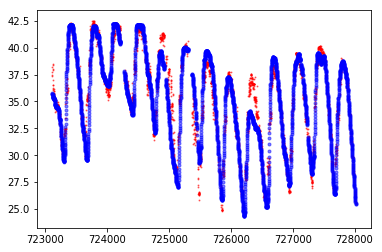

hydro_07EF003 hi {'valid_score': 0.8907094635811811, 'train_score': 0.9084564036032186}

hydro_08GB013 hi None



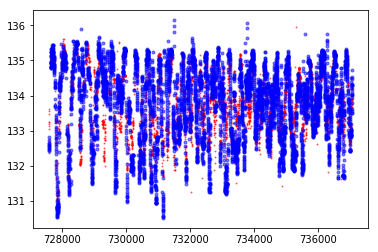

hydro_08HB082 hi {'valid_score': 0.5279966447536457, 'train_score': 0.5880953176702719}



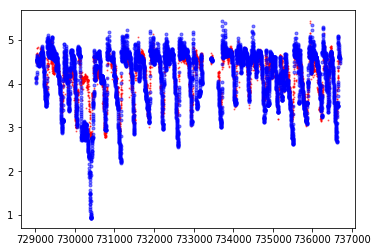

hydro_08HD025 hi {'valid_score': 0.5478143842239473, 'train_score': 0.5975695378416368}



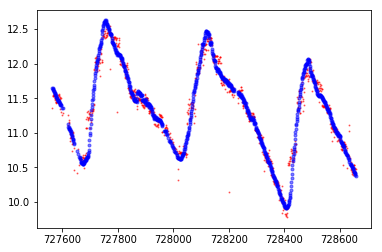

hydro_08JA022 hi {'valid_score': 0.8886381144584699, 'train_score': 0.9498157968547365}



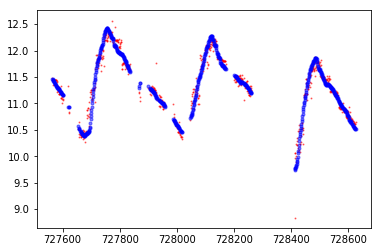

hydro_08JA023 hi {'valid_score': 0.8594982923297045, 'train_score': 0.9354310356762102}



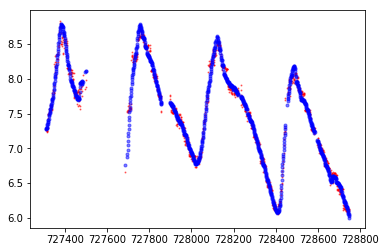

hydro_08JA027 hi {'valid_score': 0.9720583063740488, 'train_score': 0.9788136627186295}



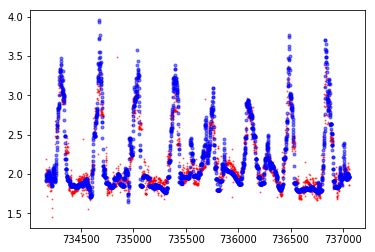

hydro_08LC018 hi {'valid_score': 0.761691930305566, 'train_score': 0.814208717804928}



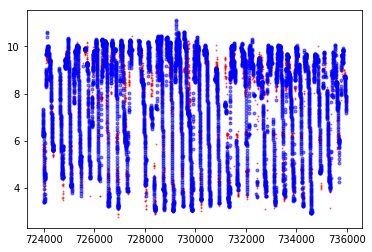

hydro_08LC041 hi {'valid_score': 0.8842203914339251, 'train_score': 0.8959937035631811}

hydro_08ME017 hi None



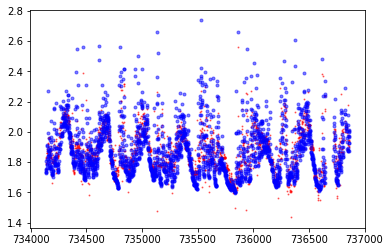

hydro_08MH141 hi {'valid_score': 0.38986810376781267, 'train_score': 0.6512409729471476}



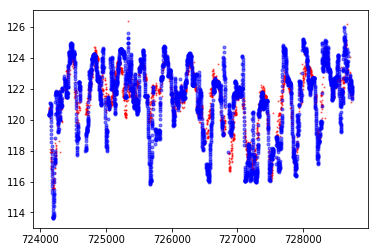

hydro_08MH148 hi {'valid_score': 0.6408531245196589, 'train_score': 0.6802450756321822}



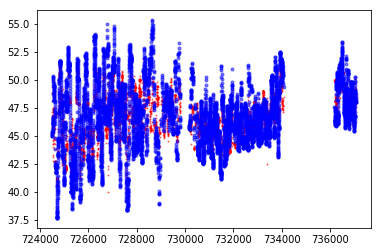

hydro_08MH149 hi {'valid_score': 0.45177231717949273, 'train_score': 0.4916265101625549}



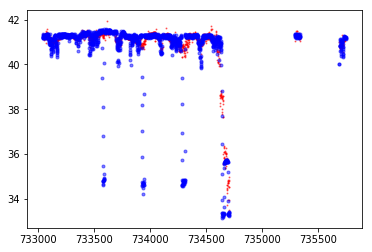

hydro_08MH167 hi {'valid_score': 0.5959127056528696, 'train_score': 0.4253613226331171}



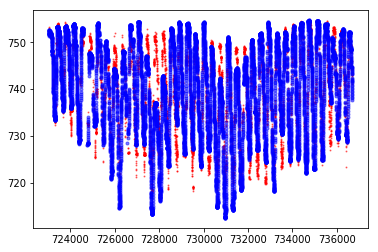

hydro_08NB017 hi {'valid_score': 0.8214173801880013, 'train_score': 0.825225672626659}



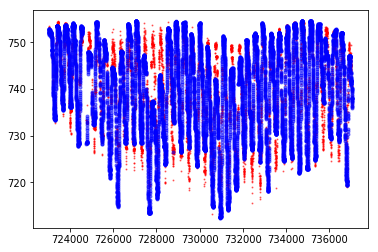

hydro_08ND017 hi {'valid_score': 0.8112298482969723, 'train_score': 0.8253245330408863}



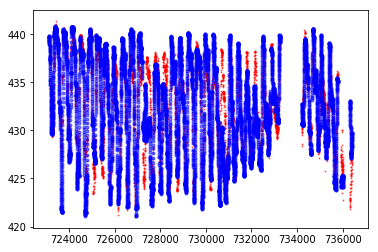

hydro_08NE102 hi {'valid_score': 0.7533693357474583, 'train_score': 0.755178907191671}



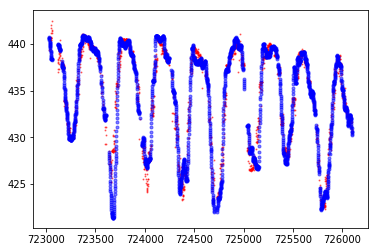

hydro_08NE103 hi {'valid_score': 0.9075629214164223, 'train_score': 0.9213350908108607}



KeyboardInterrupt: 

In [46]:
for key in keys:
    print(key, 'hi', create_models(key, show_plot=True))
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
    #plot_errors(model, X_valid, y_valid, key)

In [ ]:
# k1 = 5.0**2 * RBF(length_scale=3.0) *  ExpSineSquared(length_scale=1.3, periodicity=1.0)  # long term smooth rising trend
#k_years = 10**2 * RBF(length_scale=3.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# k4 = 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=3**2)  # noise terms
#k = k_years


In [ ]:
# model notes
"""
drought-year outlier handling needs work
check for distribution along month? strong comp
C as a function of the mean? not if we scale
Figure out keeping labels but scaling the other stuff
coquitlam lake??? snowfall
compare models when training on monthly subsets of the data
group into months and then train models5
"""

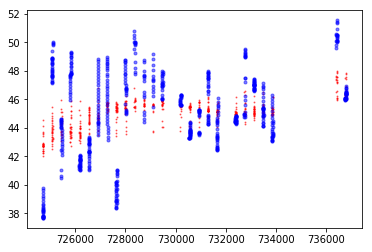

{'train_score': 0.1771081039541852, 'valid_score': 0.047525663981226034}

In [19]:
create_models('hydro_08MH149',3, True)

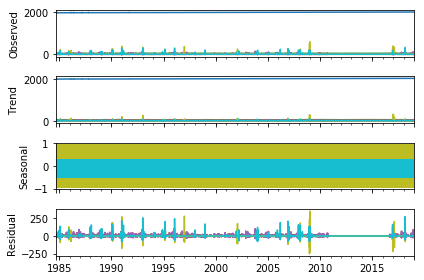

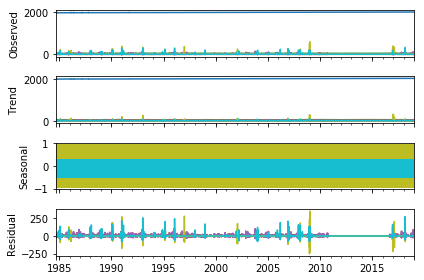

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_hdf('combined_data.hdf', key='hydro_08MH149').sort_index()
X = df.asfreq('D')
imputed_df = pd.DataFrame(SimpleImputer().fit_transform(X), columns=X.columns, index=X.index)

seasonal_decompose(imputed_df).plot() #???